# Аналитика рынка заведений общественного питания Москвы

**Цель проекта** - изучение данных о рынке заведений общественного питания в Москве. На основе полученной информации о географическом местоположении, типах заведения, числе посадочных мест, принадлежности к сети требуется дать рекомендации заказчику, планирующему открыть инновационное кафе. 

В ходе исследования решается ряд **задач**:
- подготовка данных; 
- проведение анализа информации:
    + определение соотношения количества заведений разных типов;
    + исследование заведений в разрезе сетевых и несетевых точек - распространенность типов, посадочные места;
    + выявление информации о географическом расположении заведений;
    + выбор улиц с максимаьным и минимальным количеством точек на них;
- подготовка рекомндаций.  

# Обзор информации <a name="review"></a>

Импорт библиотек, которые потребуются для выполнения исследования:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import BytesIO
import requests

### **Загрузка датафрейма** <a name="download"></a>

Считывание файлов с данными в датафрейм:

In [2]:
rest = pd.read_csv('/datasets/rest_data.csv')

Получение данных о первых 10 строках таблицы **rest**:

In [3]:
rest.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


Общая информация о данных таблицы **rest**:

In [4]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В датафрейме **rest** представлена информация о заведениях общепита в Москве. В нем 6 столбцов: 

- **id** - идентификатор заведения / целочисл. тип данных
- **object_name** - название заведения / строковый тип данных
- **chain** - сетевой ресторан или нет / строковый тип данных
- **object_type** - тип заведения / строковый тип данных
- **address** - адрес / строковый тип данных
- **number** - число посадочных мест /целочисл. тип данных

Общее количество записей о ресторанах - 15366. Пропусков нет.

---

### **Подготовка данных** <a name="preparation"></a>

Прежде всего проверим таблицу на наличие полностью повторяющихся строк:

In [5]:
rest.duplicated().sum()

0

Полных дубликатов в данных нет. Теперь рассмотрим отдельно столбцы каждой таблицы на предмет наличия ошибок в данных, а также приведем их к нужным типам там, где это необходимо. 

**id** - идентификатор заведения

Столбец **id** отдельно рассматривать на аномалии особо не имеет смысла, т.к. это всего лишь неотрицательные (предположительно) числа:

In [6]:
print(rest['id'].min())
print(rest['id'].max())

838
223439


In [7]:
rest['id'].nunique()

15366

Повторяющихся id в датафрейме нет.

Для экономии памяти поменяем тип данных с int64 на int32:

In [8]:
rest['id'] = rest['id'].astype('int32')

**object_name** - название заведения 

In [9]:
rest['object_name'].describe()

count        15366
unique       10393
top       Столовая
freq           267
Name: object_name, dtype: object

In [10]:
rest['object_name'].value_counts().head(10)

Столовая           267
Кафе               236
Шаурма             234
KFC                155
Шоколадница        142
Бургер Кинг        122
Макдоналдс         122
Домино'с Пицца      86
Теремок             84
Крошка Картошка     82
Name: object_name, dtype: int64

Две трети заведений носят не повторяющиеся имена. Остальные называются незамысловато, признак не уникален (столовые, кафе, шаурма, сетевые рестораны и т.п.).

Тип данных корректный.

**chain** - сетевой ресторан 

In [11]:
rest['chain'].describe()

count     15366
unique        2
top         нет
freq      12398
Name: chain, dtype: object

In [12]:
rest['chain'].head()

0    нет
1    нет
2    нет
3     да
4    нет
Name: chain, dtype: object

В столбце встречаются всего два значения - да и нет. Несетевых ресторанов больше: 12 398 против 2 968 сетевых. Для экономии памяти приведем данные к типу bool:

In [13]:
rest['chain'] = [True if (i == 'да') else False for i in rest['chain']]

In [14]:
rest['chain'].describe()

count     15366
unique        2
top       False
freq      12398
Name: chain, dtype: object

In [15]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int32
object_name    15366 non-null object
chain          15366 non-null bool
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: bool(1), int32(1), int64(1), object(3)
memory usage: 555.3+ KB


**object_type** - тип заведения 

In [16]:
rest['object_type'].describe()

count     15366
unique        9
top        кафе
freq       6099
Name: object_type, dtype: object

Всего 9 типов заведений:

In [17]:
rest['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Дублирующих друг друга типов нет.

Переименуем предприятия быстрого обслуживания в фастфуд, а магазины с отделами кулинарии просто в кулинарию для компактности:

In [18]:
rest['object_type'] = rest['object_type'].str.replace('предприятие быстрого обслуживания', 'фастфуд')
rest['object_type'] = rest['object_type'].str.replace('магазин \(отдел кулинарии\)', 'кулинария')

**address** - адрес

In [19]:
rest['address'].describe()

count                                      15366
unique                                      9108
top       город Москва, Ходынский бульвар, дом 4
freq                                          95
Name: address, dtype: object

Исключать дубликаты не следует, поскольку по одному и тому же адресу может находиться несколько точек общепита, особенно это касается торговых центров.

**number** - число посадочных мест

In [20]:
print(rest['number'].min())
print(rest['number'].max())

0
1700


Рассмотрим, сколько записей о ресторанах, в которых число посадочных мест нулевое:

In [21]:
rest.query('number == 0').shape[0]

1621

Таких заведений 1621. Это достаточно много по отношению к общему количеству записей. Рассмотрим в разрезе типа заведений:

In [22]:
rest.query('number == 0').groupby(by = 'object_type').agg({'id' : 'count'}).reset_index()\
                         .rename(columns = {'id':'num_id'})

,object_type,num_id
0,бар,28
1,буфет,68
2,закусочная,189
3,кафе,310
4,кафетерий,113
5,кулинария,145
6,ресторан,45
7,столовая,19
8,фастфуд,704


Можно допустить, что в некоторых барах, буфетах, закусочных, столовых действительно отсутствуют посадочные места. Также это справедливо для отделов кулинарии. Что касается остальных точек, то, во-первых, заведение может располагаться на фуд-корте в ТЦ, где посадочные места не привязаны к какому-либо конкретному ресторану. Во-вторых, есть заведения, которые готовят только под доставку, т.н. дарк-китчен. Оставим данные как есть, поскольку заполнение нулей средними значениями может исказить картину.

Что касается верхней границы, то заведений с большим числом посадочных мест не так и много:

In [23]:
rest.query('number >= 1000')

,id,object_name,chain,object_type,address,number
2313,26560,Ресторан «АЛЬФА»,False,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",1040
3686,27026,РУМ СЕРВИС,False,ресторан,"город Москва, площадь Европы, дом 2",1200
4480,27024,РУМ СЕРВИС,False,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200
8148,80291,Банкетный зал Шелк,False,ресторан,"город Москва, Большой Саввинский переулок, дом...",1500
8345,27750,СТОЛОВАЯ-БУФЕТ,False,столовая,"город Москва, улица Волхонка, дом 15",1400
9064,19719,КОМБИНАТ ПИТАНИЯ «УПРАВЛЕНИЕ АКАДЕМСЕРВИС»,False,столовая,"город Москва, проспект Вернадского, дом 84, ст...",1288
12723,199696,Arena by Soho Family,False,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700


Беглый поиск в Google подтверждает информацию о столь большом числе посадочных мест (например, [здесь](https://data.mos.ru/opendata/7710881420-kombinaty-pitaniya/row/20731002?pageNumber=2&versionNumber=1&releaseNumber=1) и [здесь](https://www.pogostite.ru/conferenc-zaly/moskva/arena-soho-family)).

Для экономии памяти поменяем тип данных с int64 на int16:

In [24]:
rest['number'] = rest['number'].astype('int16')

Наконец, попробуем найти дубликаты в таблице, не учитывая id, а по комбинации остальных параметров: 

In [25]:
dupl_rows = rest[rest.duplicated(['object_name', 'object_type', 'address', 'number'])]
display(dupl_rows.head())
print('Количество дубликатов:', dupl_rows.shape[0])

,id,object_name,chain,object_type,address,number
2381,28611,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,False,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
3481,20914,Буфет Мади,False,буфет,"город Москва, Ленинградский проспект, дом 64",40
4431,23759,СТОЛОВАЯ ГБОУ города Москвы № 384,False,буфет,"город Москва, Беловежская улица, дом 67",100
4537,23391,Столовая «Комбинат питания КОСМОС»,False,столовая,"город Москва, Новозаводская улица, дом 12/11",15
5059,20021,LIFT,False,кафе,"город Москва, Багратионовский проезд, дом 7, к...",20


Количество дубликатов: 82


In [26]:
dupl_rows['object_name'].unique()

array(['КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА', 'Буфет Мади',
       'СТОЛОВАЯ ГБОУ города Москвы № 384',
       'Столовая «Комбинат питания КОСМОС»', 'LIFT', 'Кафе при АЗС',
       'Кафе', 'Алекс', 'Павильон «Кукуруза»', 'Лиор', 'БАР',
       'СТОЛОВАЯ при МГУ', 'Кофе Хаус', 'Кафе Лукойл', 'Кафе Трасса',
       'Шаурма', 'Каменев Василий Владимирович',
       'Ибрагимов Магомед Сулейманович', 'Пункт питания', 'Буфет',
       'Кафетерий', 'Кофе с собой', 'Доннер (шаурма)',
       'Гацоева Анжела Камалдиновна', 'Закусочная', 'Гришаев В.В',
       'Осетинские пироги', 'LALTRO BOSCO', 'Пекарня', 'Пунк питания',
       'Бистро', 'Шурма', 'Старый Баку', 'Буфет при кинотеатре',
       'Sushi-Make', 'Макдоналдс'], dtype=object)

In [27]:
rest.shape[0]

15366

Удалим все дубликаты:

In [28]:
rest = rest.query('id not in @dupl_rows.id')
rest.shape[0]

15284

Таким образом, в исходном датафрейме был заменен тип столбца **chain** на bool, столбца **id** на int32, столбца **number** на int16. Без потери смысла переименованы несколько категорий заведений для компактного отображения на графиках в дальнейшем, а также исключены дубликаты по совокупности факторов (название + тип заведения + адрес + число посадочных мест).

Теперь можно приступать к анализу данных.

# Анализ данных <a name="analysis"></a>

### **Соотношение видов объектов общественного питания по количеству** <a name="types"></a>

Рассмотрим, как распределились точки общепита в зависимости от типа заведения:

In [29]:
kind = rest.groupby(by = 'object_type').agg({'id' : 'count'}).reset_index()\
                         .rename(columns = {'id':'num_id'}).sort_values(by = 'num_id', ascending = False)
kind

,object_type,num_id
3,кафе,6071
7,столовая,2584
6,ресторан,2282
8,фастфуд,1898
0,бар,855
1,буфет,577
4,кафетерий,395
2,закусочная,349
5,кулинария,273


In [30]:
sns.set_palette('bright') 

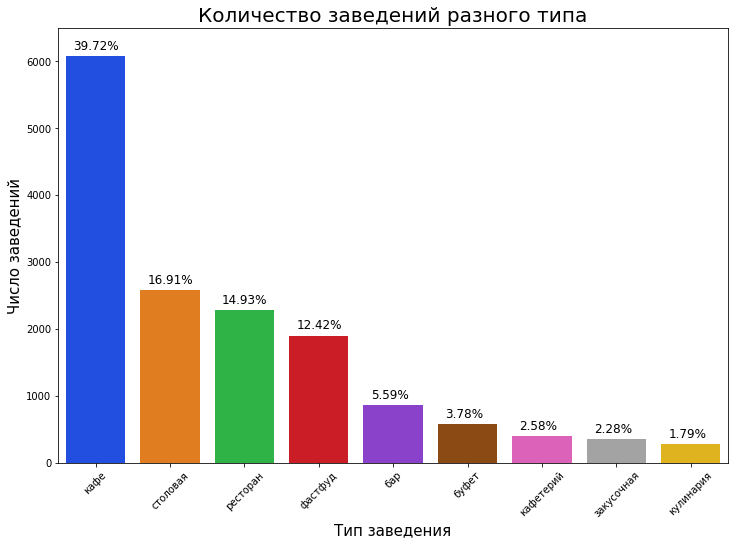

In [31]:
plt.figure(figsize=(12, 8))
fig = sns.barplot(x = "object_type", y = "num_id", data = kind) 
fig.set_title("Количество заведений разного типа", fontsize = 20)
fig.set_xlabel("Тип заведения", fontsize = 15)
fig.set_ylabel("Число заведений", fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

totals = []
for i in fig.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in fig.patches:
    fig.text(i.get_x() + 0.1, i.get_height() + 100, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=12,
                color='black')
plt.ylim(0,6500)
plt.show()

Подавляющее большинство заведений в Москве - это кафе. Их более 6 000. Все остальные существенно отстают: столовых около 2 600, ресторанов - 2 300, заведений фастфуда - 1900. Доля прочих заведений совсем незначительна. 

### **Соотношение сетевых и несетевых объектов общественного питания по количеству** <a name="chain"></a>

Посмотрим на показатели в разрезе сетей:

In [32]:
chain = rest.groupby(by = 'chain').agg({'id' : 'count'}).reset_index()\
                         .rename(columns = {'id':'num_id'}).sort_values(by = 'num_id', ascending = False)
chain['label'] = ['Сетевой' if (i == True) else 'Несетевой' for i in chain['chain']]
chain

,chain,num_id,label
0,False,12320,Несетевой
1,True,2964,Сетевой


Несетевых заведений в 4,1 раз больше, чем сетевых.

Распределение посадочных мест:

In [33]:
chain_seats = rest.groupby(by = 'chain').agg({'number' : 'sum'}).reset_index()\
                         .rename(columns = {'number':'num_seats'}).sort_values(by = 'num_seats', ascending = False)
chain_seats['label'] = ['Сетевой' if (i == True) else 'Несетевой' for i in chain_seats['chain']]
chain_seats

,chain,num_seats,label
0,False,756708.0,Несетевой
1,True,157036.0,Сетевой


Посадочных мест в несетевых заведениях в 4,8 раз больше, чем в сетевых.

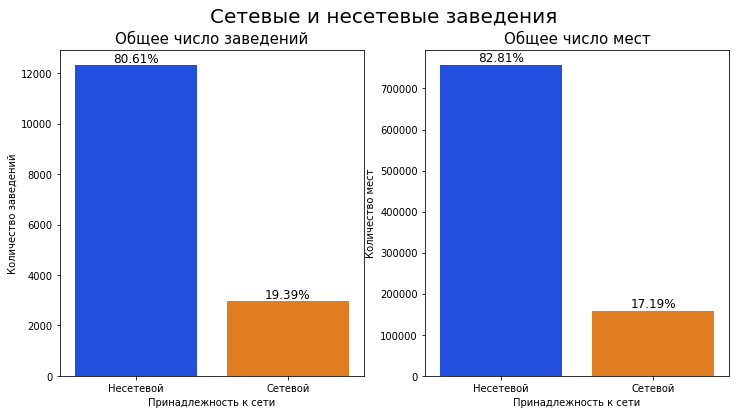

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Сетевые и несетевые заведения', fontsize = 20)

fig1 = sns.barplot(ax=axes[0], x = "label", y = "num_id", data = chain) 
fig1.set_title("Общее число заведений", fontsize = 15)
fig1.set_xlabel("Принадлежность к сети", fontsize = 10)
fig1.set_ylabel("Количество заведений", fontsize = 10)

totals1 = []
for i in fig1.patches:
    totals1.append(i.get_height())
    
total1 = sum(totals1)

for i in fig1.patches:
    fig1.text(i.get_x() + 0.25, i.get_height() + 100, \
            str(round((i.get_height() / total1) * 100, 2)) + '%', fontsize=12,
                color='black')

fig2 = sns.barplot(ax=axes[1], x = "label", y = "num_seats", data = chain_seats) 
fig2.set_title("Общее число мест", fontsize = 15)
fig2.set_xlabel("Принадлежность к сети", fontsize = 10)
fig2.set_ylabel("Количество мест", fontsize = 10)

totals2 = []
for i in fig2.patches:
    totals2.append(i.get_height())
    
total2 = sum(totals2)

for i in fig2.patches:
    fig2.text(i.get_x() + 0.25, i.get_height() + 10000, \
            str(round((i.get_height() / total2) * 100, 2)) + '%', fontsize=12,
                color='black')
plt.show()

### **Сетевое распространение в разрезе типов заведений** <a name="chain_types"></a>

Рассмотрим, как распределились сетевые и несетевые заведения в зависимости от их типа:

In [35]:
kind_chain = rest.query('chain == True').groupby(by = 'object_type').agg({'id' : 'count'}).reset_index()\
                         .rename(columns = {'id':'num_id_chain'})\
                         .sort_values(by = 'num_id_chain', ascending = False)
kind_chain

,object_type,num_id_chain
3,кафе,1396
8,фастфуд,788
6,ресторан,543
5,кулинария,78
2,закусочная,56
4,кафетерий,52
0,бар,37
1,буфет,11
7,столовая,3


In [36]:
kind_unchain = rest.query('chain == False').groupby(by = 'object_type').agg({'id' : 'count'}).reset_index()\
                         .rename(columns = {'id':'num_id_unchain'})\
                         .sort_values(by = 'num_id_unchain', ascending = False)
kind_unchain

,object_type,num_id_unchain
3,кафе,4675
7,столовая,2581
6,ресторан,1739
8,фастфуд,1110
0,бар,818
1,буфет,566
4,кафетерий,343
2,закусочная,293
5,кулинария,195


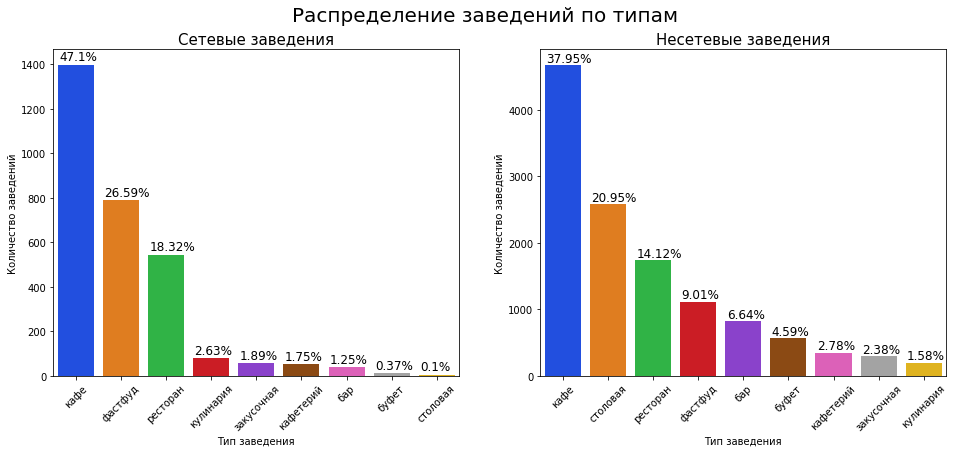

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Распределение заведений по типам', fontsize = 20)

fig1 = sns.barplot(ax=axes[0], x = "object_type", y = "num_id_chain", data = kind_chain) 
fig1.set_title("Сетевые заведения", fontsize = 15)
fig1.set_xlabel("Тип заведения", fontsize = 10)
fig1.set_ylabel("Количество заведений", fontsize = 10)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

totals1 = []
for i in fig1.patches:
    totals1.append(i.get_height())
    
total1 = sum(totals1)

for i in fig1.patches:
    fig1.text(i.get_x() + 0.03, i.get_height() + 20, \
            str(round((i.get_height() / total1) * 100, 2)) + '%', fontsize=12,
                color='black')

fig2 = sns.barplot(ax=axes[1], x = "object_type", y = "num_id_unchain", data = kind_unchain) 
fig2.set_title("Несетевые заведения", fontsize = 15)
fig2.set_xlabel("Тип заведения", fontsize = 10)
fig2.set_ylabel("Количество заведений", fontsize = 10)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

totals2 = []
for i in fig2.patches:
    totals2.append(i.get_height())
    
total2 = sum(totals2)

for i in fig2.patches:
    fig2.text(i.get_x() + 0.03, i.get_height() + 50, \
            str(round((i.get_height() / total2) * 100, 2)) + '%', fontsize=12,
                color='black')
plt.show()

Мы видим, что среди сетевых заведений лидируют кафе, фастфуд, рестораны. Среди несетевых - кафе, столовые и снова рестораны.

Теперь рассмотрим отношение между сетевыми и несетевыми заведениями внутри каждой категории:

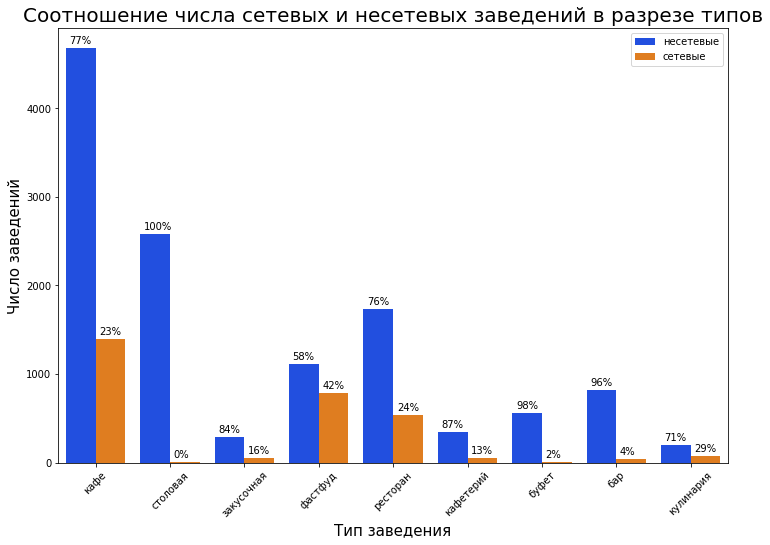

In [38]:
plt.figure(figsize=(12, 8))
fig = sns.countplot(x = "object_type", hue = 'chain', data = rest)
fig.set_title("Соотношение числа сетевых и несетевых заведений в разрезе типов", fontsize = 20)
fig.set_xlabel("Тип заведения", fontsize = 15)
fig.set_ylabel("Число заведений", fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.legend(["несетевые", "сетевые"])

patch = fig.patches
half = int(len(patch)/2)
for i in range(half):
    p1= patch[i]
    p2 = patch[i + half]
    height_1 = p1.get_height()
    height_2 = p2.get_height()
    total = height_1 + height_2
    width_1 = p1.get_x() + p1.get_width() / 2
    width_2 = p2.get_x() + p2.get_width() / 2
    fig.text(width_1 - 0.15, height_1 + 50,"{:.0%}".format(height_1 / total))
    fig.text(width_2 - 0.15, height_2 + 50,"{:.0%}".format(height_2 / total))       
plt.show()

Как видно, в сравнительном выражении только количество заведений фастфуда более-менее близко у обеих групп. Число кафе, ресторанов и точек кулинарии различается примерно в три раза в пользу несетевых заведений. В остальных категориях практически все точки относятся к несетевым.

### **Посадочные места в сетевых заведениях** <a name="seats_chain"></a>

Сгруппируем данные по названию сети и отразим среднее число посадочных мест внутри каждой сети на графике. В качестве среднего выберем медиану, поскольку характер распределения посадочных мест отличается от нормального.

In [39]:
seats_chain = rest.query('chain == True').groupby(by = 'object_name').agg({'id':'count', 'number':'median'}).reset_index()\
                               .rename(columns = {'id':'num_id', 'number':'avg_number'})\
                               .sort_values(by = 'avg_number', ascending = False)

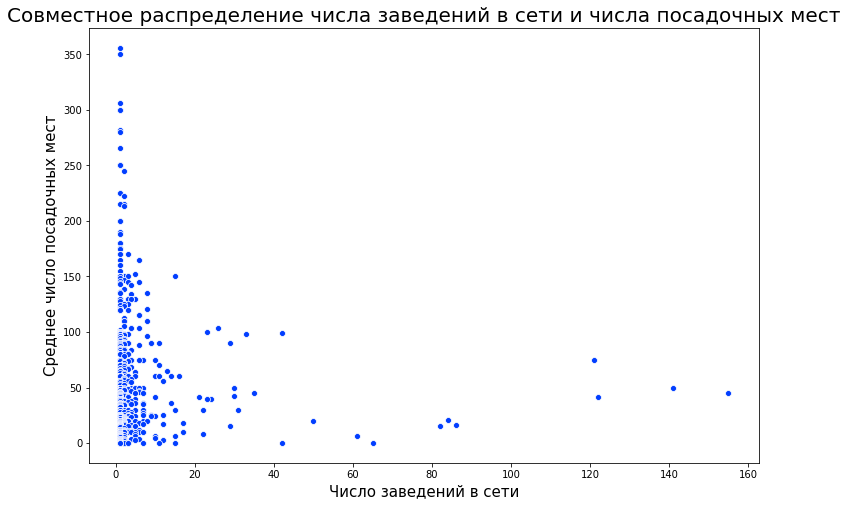

In [40]:
plt.figure(figsize=(12, 8))
fig = sns.scatterplot(x = "num_id", y = "avg_number", data = seats_chain)
fig.set_title("Совместное распределение числа заведений в сети и числа посадочных мест", fontsize = 20)
fig.set_xlabel("Число заведений в сети", fontsize = 15)
fig.set_ylabel("Среднее число посадочных мест", fontsize = 15)
plt.show()

Как видно, почти все точки располагаются в левой части графика, причем концентрация выше в углу. Это говорит о том, что для сетевых заведений характерно малое число заведений с большим числом посадочных мест. Основная часть сетей состоит не более чем из 6-7 заведений и менее чем 150 мест.

### **Среднее число посадочных мест в зависимости от типа заведения** <a name="mean_seats"></a>

Определим, сколько всего и в среднем посадочных мест приходится на заведения того или иного типа:

In [41]:
seats = rest.groupby(by = 'object_type').agg({'number' : 'sum'}).reset_index()\
                         .rename(columns = {'number':'num_seats'}).sort_values(by = 'num_seats', ascending = False)
seats

,object_type,num_seats
7,столовая,336793.0
3,кафе,241539.0
6,ресторан,221091.0
8,фастфуд,39494.0
0,бар,37221.0
1,буфет,29721.0
4,кафетерий,3628.0
2,закусочная,2731.0
5,кулинария,1526.0


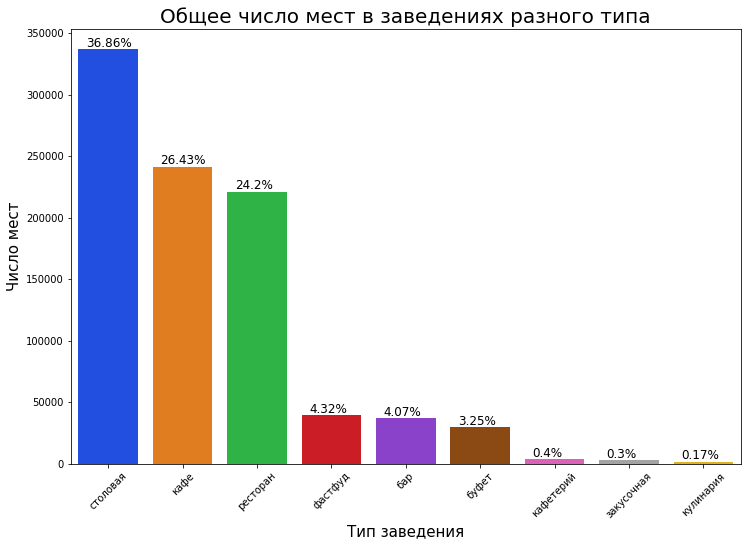

In [42]:
plt.figure(figsize=(12, 8))
fig = sns.barplot(x = "object_type", y = "num_seats", data = seats) 
fig.set_title("Общее число мест в заведениях разного типа", fontsize = 20)
fig.set_xlabel("Тип заведения", fontsize = 15)
fig.set_ylabel("Число мест", fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

totals = []
for i in fig.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in fig.patches:
    fig.text(i.get_x() + 0.1, i.get_height() + 2000, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=12,
                color='black')
plt.show()

Несмотря на то, что на кафе приходится самая большая доля всех заведений, по суммарному количеству мест (241 500) они уступают столовым (337 000). На третьем месте рестораны (221 000).

In [43]:
seats1 = rest.groupby(by = 'object_type')

Средние значения:

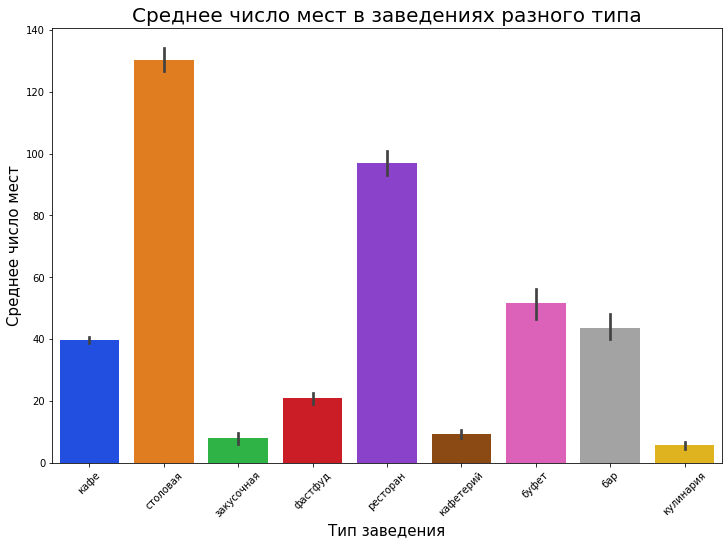

In [44]:
plt.figure(figsize=(12, 8))
fig = sns.barplot(x = "object_type", y = "number", data = rest) 
fig.set_title("Среднее число мест в заведениях разного типа", fontsize = 20)
fig.set_xlabel("Тип заведения", fontsize = 15)
fig.set_ylabel("Среднее число мест", fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
plt.show()

По среднему количеству мест лидируют столовые и рестораны.

### **Выделение информации об улицах** <a name="streets"></a>

Рассмотрим, как выглядят типичные записи об адресе заведений:

In [45]:
pd.set_option('max_colwidth', 200)
rest['address'].head(10)

0             город Москва, улица Егора Абакумова, дом 9
1      город Москва, улица Талалихина, дом 2/1, корпус 1
2              город Москва, Абельмановская улица, дом 6
3                город Москва, Абрамцевская улица, дом 1
4      город Москва, Абрамцевская улица, дом 9, корпус 1
5     город Москва, Абрамцевская улица, дом 15, корпус 1
6          город Москва, переулок Сивцев Вражек, дом 6/2
7    город Москва, Авиамоторная улица, дом 8, строение 1
8    город Москва, Авиамоторная улица, дом 8, строение 1
9    город Москва, Авиамоторная улица, дом 8, строение 1
Name: address, dtype: object

Опытным путем было выявлено, что большинство строк начинаются с города Москвы, однако в некоторых записях Москва опущена, и идет либо сразу название улицы, либо название населенного пункта, входящего в состав Москвы, а после него улица. Не будем убирать название населенного пункта, чтобы избежать путаницы с одинаковыми названиями улиц в разных географических местах (например, улица Рабочая в центре Москвы и улица Рабочая в п.Первомайское - разные объекты).

После улицы указан либо дом, либо владение, либо строение, либо корпус.

Используя выявленные закономерности, заполним новый столбец подстроками, соответствующими названиям улиц. Для этого составим функцию **extract**, которая вырезает из строки ее часть, заключенную между двумя задаваемыми на входе подстроками: 

In [46]:
# string - исходная строка, start_m - подстрока перед вырезаемой частью, 
# end_m - подстрока после вырезаемой части

# если строка не соответствует задаче (нет указанной первой или последней части), то возвращается нулевое значение

def extract(string, start_m, end_m):
    try:
        start = string.index(start_m) + len(start_m)
        end = string.index(end_m, start)
        return string[start:end]
    except:
        return 0

Создадим нужный столбец **street**, изначально состоящий только из нулей. Заполним его, применив функцию несколько раз к ячейкам столбца **address**, перебирая в цикле все возможные комбинации строк с адресом. Уже заполненные строки (ненулевые) изменяться в новых итерациях не будут:

In [47]:
rest['street'] = np.zeros(rest.shape[0])
for i in ["Москва, ", ""]:
    for j in [", дом", ", владение", ", корпус", ", строение"]:
        rest.loc[rest['street'] == 0, 'street'] = rest.apply(lambda row: extract(row['address'], i, j), axis = 1)

Проверим, что все комбинации были учтены, и ни нулей, ни пропусков не осталось:

In [48]:
rest.query('street == 0').shape[0]

0

In [49]:
rest['street'].isna().sum()

0

Теперь в таблице появился столбец с улицами:

In [50]:
rest.head(10)

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,False,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240,Абрамцевская улица
6,148815,Брусника,True,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,переулок Сивцев Вражек
7,20957,Буфет МТУСИ,False,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90,Авиамоторная улица
8,20958,КПФ СЕМЬЯ-1,False,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150,Авиамоторная улица
9,28858,Столовая МТУСИ,False,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120,Авиамоторная улица


### **Топ-10 улиц по количеству объектов общественного питания** <a name="top10"></a>

Посчитаем, где расположено больше всего объектов общепита:

In [51]:
street_pop = rest.groupby(by = 'street').agg({'id' : 'count'}).reset_index()\
                         .rename(columns = {'id':'num_id'}).sort_values(by = 'num_id', ascending = False)
street_pop.head(10)

,street,num_id
1588,проспект Мира,204
996,Профсоюзная улица,182
683,Ленинградский проспект,172
981,Пресненская набережная,167
406,Варшавское шоссе,162
686,Ленинский проспект,148
1333,город Зеленоград,129
1585,проспект Вернадского,128
674,Кутузовский проспект,114
600,Каширское шоссе,111


Проверим, почему в топ-10 улиц оказался Зеленоград:

In [52]:
rest.query('street == "город Зеленоград"').head(5)

,id,object_name,chain,object_type,address,number,street
1405,20199,ЭТО,False,кафе,"город Москва, город Зеленоград, корпус 401",35,город Зеленоград
1406,68113,Френдс,False,кафе,"город Москва, город Зеленоград, корпус 435",34,город Зеленоград
1407,20105,Кафе «Граф Монте-Кристо»,False,кафе,"город Москва, город Зеленоград, корпус 436",40,город Зеленоград
1408,22982,Альфорно,False,кафе,"город Москва, город Зеленоград, корпус 438",49,город Зеленоград
1409,151267,Альфорно,False,кафе,"город Москва, город Зеленоград, корпус 438",45,город Зеленоград


В исходных ячейках с адресами нет уточнения по улицам, на которых расположены кафе и рестораны Зеленограда. Строго говоря, эти объекты не подходят под условие задачи, поэтому уберем Зеленоград из рейтинга:

In [53]:
top_str = street_pop.query('street != "город Зеленоград"').head(10)
top_str

,street,num_id
1588,проспект Мира,204
996,Профсоюзная улица,182
683,Ленинградский проспект,172
981,Пресненская набережная,167
406,Варшавское шоссе,162
686,Ленинский проспект,148
1585,проспект Вернадского,128
674,Кутузовский проспект,114
600,Каширское шоссе,111
605,Кировоградская улица,108


Построим график:

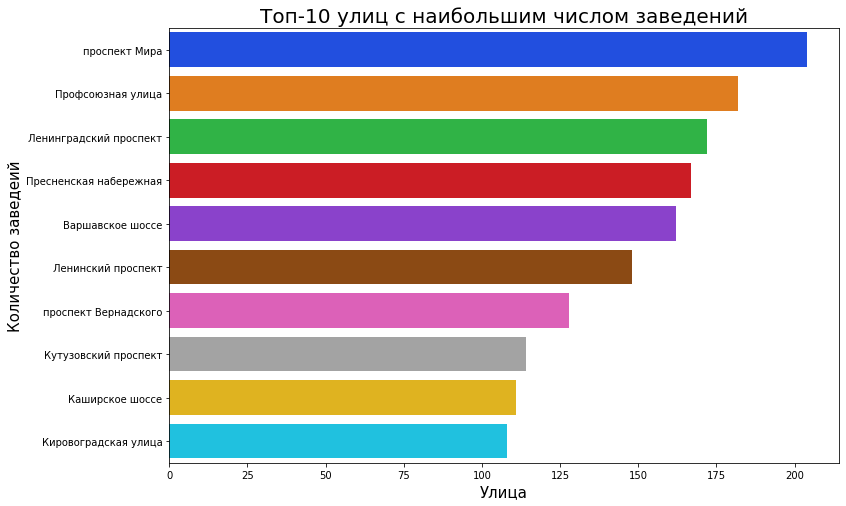

In [54]:
plt.figure(figsize=(12, 8))
fig = sns.barplot(x = "num_id", y = "street", data = top_str) 
fig.set_title("Топ-10 улиц с наибольшим числом заведений", fontsize = 20)
fig.set_xlabel("Улица", fontsize = 15)
fig.set_ylabel("Количество заведеий", fontsize = 15)
plt.show()

Для того чтобы определить, в каких районах Москвы находятся указанные улицы, воспользуемся внешним источником. Загрузим справочник улиц, районов и округов Москвы, выложенный в открытый доступ на [github](https://github.com/Distans/temp/blob/main/mosgaz-streets.csv), разместим его в Google Sheets и импортируем по ссылке:

In [55]:
file_name = 'https://docs.google.com/spreadsheets/d/1N5EgPTu1LcaQd2KNnSphJgRXYtgNspY9UH_fLnEzKZg/export?format=csv'
r = requests.get(file_name)
districts = pd.read_csv(BytesIO(r.content))

In [56]:
districts.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [57]:
districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
streetname    4398 non-null object
areaid        4398 non-null int64
okrug         4398 non-null object
area          4398 non-null object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB


В файле содержится информация об округах и районах, в которых находится та или иная улица. Сопоставим районы полученному топ-10 и сгруппируем получившийся датафрейм по названию улицы, поскольку одна улица может проходить через несколько районов:

In [58]:
top_str.merge(districts, left_on = 'street', right_on = 'streetname', how = 'inner')[['street', 'area']]\
                    .groupby(by = 'street').agg({'area':'unique'}).reset_index()

,street,area
0,Варшавское шоссе,"[Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово]"
1,Каширское шоссе,"[Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное]"
2,Кировоградская улица,"[Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное]"
3,Кутузовский проспект,"[Район Дорогомилово, Район Фили-Давыдково]"
4,Ленинградский проспект,"[Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол]"
5,Ленинский проспект,"[Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка]"
6,Пресненская набережная,[Пресненский район]
7,Профсоюзная улица,"[Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан]"
8,проспект Вернадского,"[Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район]"
9,проспект Мира,"[Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район]"


Получился довольно большой перечень районов из разных АО. По большей части их нельзя классифицировать ни как центральные, ни как окраинные. Скорее, большинство из них расположено в средней уделенности от центра Москвы.

Вероятно, в топ-10 перечисленные улицы попали благодаря своей протяженности. Так, по [данным Яндекса](https://yandex.ru/company/researches/2017/streets), средняя длина московской улицы - 934 м. Из указанных самые короткие (не считая Пресненской набережной) - Кировоградская улица и Ленинский проспект протяженностью соответственно 4,3 км и 5,6 км. Остальные растянулись более чем на 8 км. Особняком стоит короткая - всего 550 м - Пресненская набережная. Она является центром делового квартала "Москва-сити" с небоскребами, поэтому концентрация ресторанов и кафе на ней очень высока.

### **Улицы с единственным объектом общественного питания** <a name="unique_rest"></a>

Теперь определим количество улиц, на которых расположено всего одно заведение общепита, а также районы, где они находятся.

In [59]:
unique_rest_str = street_pop.query('num_id == 1')
unique_rest_str.head()

,street,num_id
759,Малый Толмачёвский переулок,1
647,Красногвардейский бульвар,1
756,Малый Саввинский переулок,1
138,2-я Филёвская улица,1
24,1-й Лучевой просек,1


Таких улиц 627. Попробуем определить для них соответствующие районы.

In [60]:
unique_rest_per_area = unique_rest_str.merge(districts, left_on = 'street', right_on = 'streetname', how = 'left')\
                      [['street', 'area']]
unique_rest_per_area.head()

,street,area
0,Малый Толмачёвский переулок,Район Якиманка
1,Красногвардейский бульвар,Пресненский район
2,Малый Саввинский переулок,Район Хамовники
3,2-я Филёвская улица,Район Филевский Парк
4,1-й Лучевой просек,Район Сокольники


Получили 673 записи (т.к. несколько улиц проходяят более чем через 1 район). Однако не все ячейки в столбце с районом оказались заполнены. Посмотрим, сколько их и чем обусловлены пропуски:

In [61]:
unique_rest_per_area.query('area.isna()').shape[0]

109

In [62]:
unique_rest_per_area.query('area.isna()').head(20)

,street,area
28,улица Старые Кузьминки,NaN
86,26-й километр Московской Кольцевой Автодороги,NaN
95,улица Высоцкого,NaN
104,улица Льва Яшина,NaN
151,104-й километр Московской Кольцевой Автодороги,NaN
158,улица Недорубова,NaN
183,улица Капотня,NaN
406,Пыжёвский переулок,NaN
471,"поселение Сосенское, посёлок Коммунарка, Фитарёвская улица",NaN
473,"поселение Сосенское, посёлок Коммунарка, микрорайон ""Эдальго""",NaN


Во-первых, нескольких улиц просто не оказалось в справочнике. Во-вторых, некоторые из них в справочнике именуются по-другому (например, МКАД), поэтому не попали в объединенную таблицу. В-третьих, в части заданных адресов вообще нет уточнения по улице (касается в основном заведений и городов).

Сначала решим вопрос с поселениями. Собственно, соответствующий район и носит название поселения:

In [63]:
unique_rest_per_area.loc[unique_rest_per_area['area'].isna() &\
                         unique_rest_per_area['street'].str.contains("поселение"), 'area'] =\
                         unique_rest_per_area.apply(lambda row: extract(row['street'], "", ","), axis = 1)
unique_rest_per_area.head()

,street,area
0,Малый Толмачёвский переулок,Район Якиманка
1,Красногвардейский бульвар,Пресненский район
2,Малый Саввинский переулок,Район Хамовники
3,2-я Филёвская улица,Район Филевский Парк
4,1-й Лучевой просек,Район Сокольники


In [64]:
unique_rest_per_area.query('area.isna()').shape[0]

41

Вместо 109 осталась 41 пустая строчка:

In [65]:
unique_rest_per_area.query('area.isna()').head(20)

,street,area
28,улица Старые Кузьминки,NaN
86,26-й километр Московской Кольцевой Автодороги,NaN
95,улица Высоцкого,NaN
104,улица Льва Яшина,NaN
151,104-й километр Московской Кольцевой Автодороги,NaN
158,улица Недорубова,NaN
183,улица Капотня,NaN
406,Пыжёвский переулок,NaN
523,34-й километр Московской Кольцевой Автодороги,NaN
530,31-й километр Московской Кольцевой Автодороги,NaN


С городами можно поступить так же, как и с поселениями:

In [66]:
unique_rest_per_area.loc[unique_rest_per_area['area'].isna() &\
                         unique_rest_per_area['street'].str.contains("город"), 'area'] =\
                         unique_rest_per_area.apply(lambda row: extract(row['street'], "", ","), axis = 1)

In [67]:
unique_rest_per_area.query('area.isna()').shape[0]

22

Осталось всего 22 незаполненных ячейки, что уже непринципиально для дальнейшего анализа (при желании можно было бы указать районы вручную), поэтому удалим их из таблицы:

In [68]:
unique_rest_per_area = unique_rest_per_area.query('~area.isna()')

In [69]:
unique_rest_per_area.shape[0]

651

Посмотрим, в каких районах чаще всего встречаются улицы с единственным заведением общепита:

In [70]:
unique_rest_per_area.groupby(by = 'area').agg({'street':'count'}).reset_index()\
                    .sort_values(by = 'street', ascending = False).rename(columns = {'street':'num_streets'}).head(10)

,area,num_streets
95,Таганский район,27
81,Район Хамовники,26
3,Басманный район,25
20,Пресненский район,20
96,Тверской район,20
51,Район Марьина роща,18
21,Район Арбат,18
13,Мещанский район,15
75,Район Сокольники,15
33,Район Замоскворечье,14


Все указанные районы располагаются в самом центре Москвы. Вероятно, этот феномен можно обосновать тем, что в центре сохранилось много коротких улиц.

### **Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания** <a name="num_top10"></a>

Посмотрим на топ-10 улиц по количеству заведений общепита с точки зрения числа посадочных мест:

In [71]:
rest.query('street in @top_str.street').shape[0]

1496

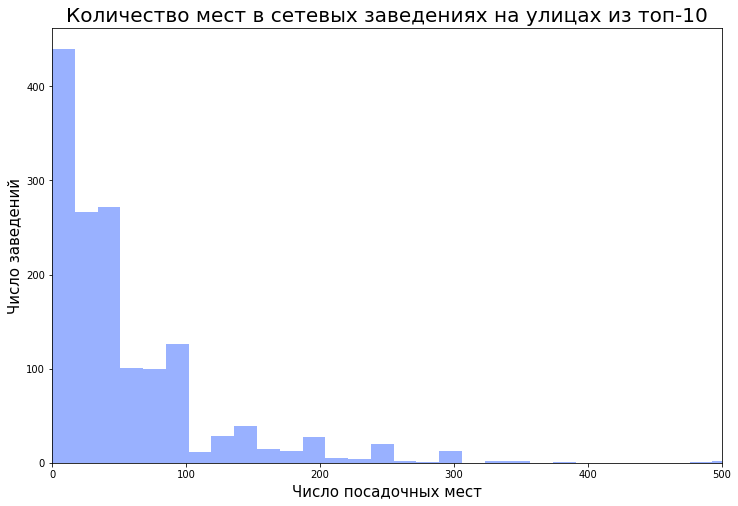

In [72]:
plt.figure(figsize=(12, 8))
fig = sns.distplot(rest.query('street in @top_str.street')['number'], bins = 100, kde = False)
fig.set_title("Количество мест в сетевых заведениях на улицах из топ-10", fontsize = 20)
fig.set_xlabel("Число посадочных мест", fontsize = 15)
fig.set_ylabel("Число заведений", fontsize = 15)
plt.xlim(0,500)
plt.show()

Из полутора тысяч таких заведений основная часть приходится на точки, в которых до 50 мест.

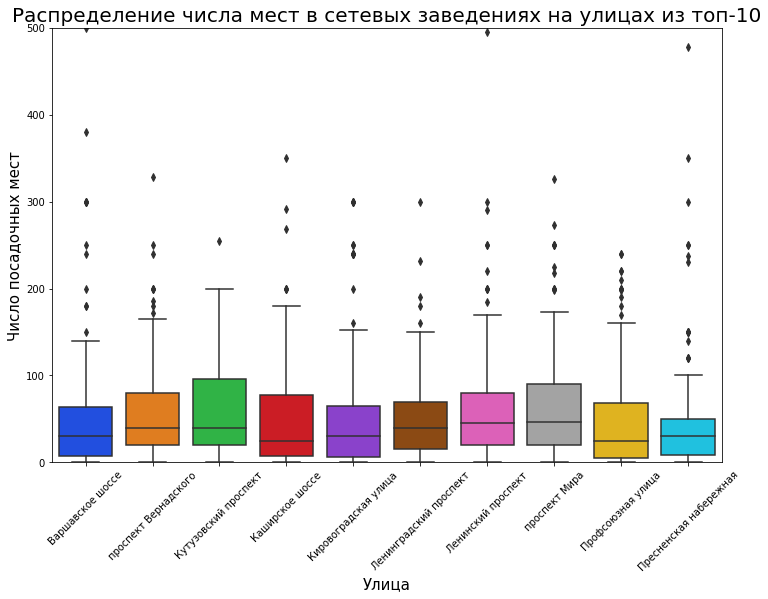

In [73]:
plt.figure(figsize=(12, 8))
fig = sns.boxplot(x='street', y="number", data=rest.query('street in @top_str.street'))
fig.set_title("Распределение числа мест в сетевых заведениях на улицах из топ-10", fontsize = 20)
fig.set_xlabel("Улица", fontsize = 15)
fig.set_ylabel("Число посадочных мест", fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
plt.ylim(0,500)
plt.show()

В разрезе улиц из топ-10 распределения числа посадочных мест не сильно отличаются друг от друга. Чуть выше медиана и третий квартиль у заведений на Кутузовском, Ленинском проспекте и проспекте Мира. Более компактные рестораны находятся на Варшавском шоссе и Пресненской набережной.

# Вывод и рекомендации <a name="conclusion"></a>

Подавляющее большинство заведений общепита в Москве - это кафе, доля которых составляет около 40% (6000 из 15 300). За ними расположились столовые и заведения фастфуда (примерно по 15%). Доля прочих заведений совсем незначительна. При этом несмотря на меньшую популярность столовых, они лидируют по количеству посадочных мест (36%, примерно 337 000 из 914 000), затем кафе (26%) и рестораны (24%). Такой перекос в сторону столовых можно объяснить тем, что они, как правило, располагаются рядом с крупными предприятиями или учебными заведениями, что обуславливает большой приток посетителей, желающих недорого поесть.

Встречаются заведения и совсем без посадочных мест. Наиболее характерно это для совсем мелких точек фастфуда и закусочных, а также некоторых кафе. Кроме того, что часть заведений может располагаться на фуд-корте в ТЦ, где посадочные места не привязаны к какому-либо конкретному ресторану, либо спецификой заведения (готовят только под доставку).

Несетевые заведение преобладают над сетевыми как по общему количеству (12 300 против 2 900, в 4,1 раза), так и по числу посадочных мест (756 000 против 157 000, в 4,8 раз). Среди несетевых точек больше всего кафе, заведений фастфуда и ресторанов, а среди сетевых - кафе, столовых и ресторанов. Среди сетевых заведений преобладают точки с небольшим (до 50) числом посадочных мест.

В среднем наибольшее число посадочных мест предлагают столовые и рестораны, несмотря на распространенность кафе в абсолютном выражении.

Улицы из топ-10 по числу заведений довольно протяженные и проходят через несколько районов, что и обуславливает их лидирующие позиции. Эти районы расположены не в историческом центре Москвы, однако в большинстве и не на окраинах (Тропарево-Никулино, Раменки, Беговой, Аэропорт, Дорогомилово, Фили-Давыдково, Гагаринский, Ломоносовский и пр.). Встречаются и удаленные от центра районы (Чертаново, Бутово, Теплый Стан и пр.). Из полутора тысяч таких заведений основная масса представляет собой небольшие кафе с числом посадочных мест до 50 (вероятно, аренда обходится довольно дорого). Несколько более вместительные заведения находятся на Кутузовском, Ленинском проспекте и проспекте Мира. В среднем меньше посадочных мест в точках на Варшавском шоссе и Пресненской набережной.

Улицы, на которых располагается только один объект общественного питания, напротив, находятся в историческом центре: Таганский район, Хамовники, Пресненский, Тверской, Арбат и пр. Причина - непродолжительная длина центральных улиц.

---
На основании проведенного анализа можно сделать следующие выводы и рекомендации:

- полученной информации явно недостаточно, чтобы делать выводы о рентабельности открываемой точки. Такие важные факторы, как проходимость места, наличие рядом крупных бизнес- и офисных центров, достопримечательностей, привлекающих туристов каждый год, отелей и т.п., остались неохваченными. Также недостает данных в части стоимости аренды помещений, среднего чека заведений.
- открытие типичного для центра небольшого кафе на 30-40 мест могло бы осуществиться с расчетом в первую очередь на туристов. Поскольку поток будет состоять преимущественно не из постоянных клиентов, необычная идея с роботами-официантами будет привлекать все новых любопытных посетителей. Возможно, с помощью рекламы в путеводителях и на туристических сайтах удастся обеспечить высокую посещаемость. В этом случае следует учесть высокие первоначальные затраты (вложение в оформление заведения - столовая неуместна в элитном месте), а также большую стоимость аренды. Также необходимо внимательно отнестись к выбору адреса: многие улицы в центре короткие, и расположение поблизости нескольких конкурентов может не позволить заведению окупиться. 
- выбор места на одной из топовых улиц может быть экономически обусловлен, даже несмотря на конкуренцию. Как один из вариантов можно рассмотреть деловой центр "Москва-Сити" на Пресненской набережной. Огромное количество бизнес-центров обеспечит солидный приток посетителей даже при высокой концентрации кафе и ресторанов, а креативная идея использования роботов-официантов подходит концепции самого современного и инновационного района столицы.
